# Crashspot – Week 6 Starter

**Focus:** Model enhancement + class imbalance handling + third model

In [6]:

# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             RocCurveDisplay, PrecisionRecallDisplay, 
                             accuracy_score, f1_score)
from sklearn.utils.class_weight import compute_class_weight

# Optional: SMOTE (may not be installed). We'll try and fallback gracefully.
try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except Exception as e:
    HAS_SMOTE = False
    print("SMOTE not available; proceeding without it. To enable: pip install imbalanced-learn")

# Paths (assuming this notebook lives in Crashspot/notebooks/)
DATA_PATH = "../data_clean/week5_features.csv"
FIG_DIR = "../docs/figures"
MODEL_DIR = "../models"

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Load Week 5 engineered dataset
df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape)
df.head()


Loaded: (60, 9)


,hour,month,weekday,is_weekend,is_night,ve_total,persons,peds,target_multiveh
0,6,1,4,0,0,2,3,0,1
1,22,1,2,0,1,1,3,1,0
2,13,3,3,0,0,1,2,0,0
3,10,2,1,0,0,2,2,0,1
4,19,3,4,0,0,1,1,1,0


In [7]:

# Features/target
target = "target_multiveh"
X = df.drop(columns=[target])
y = df[target]

# Train/Val/Test split: 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
y.value_counts(normalize=True).rename("class_ratio")


Train: (42, 8) Val: (9, 8) Test: (9, 8)


target_multiveh
0    0.583333
1    0.416667
Name: class_ratio, dtype: float64

## Strategy A: Class weights (balanced)

In [8]:

# Logistic Regression with class_weight
lr = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
lr.fit(X_train, y_train)

# Random Forest with class_weight
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)

# Gradient Boosting (no native class_weight) — baseline third model
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

models = {"LogReg_bal": lr, "RF_bal": rf, "GB": gb}

# Validate
val_rows = []
for name, m in models.items():
    y_pred = m.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    val_rows.append({"model": name, "val_accuracy": acc, "val_f1": f1})
    print(f"\n=== {name} (Validation) ===")
    print(classification_report(y_val, y_pred, digits=3))
pd.DataFrame(val_rows).sort_values("val_f1", ascending=False)



=== LogReg_bal (Validation) ===
              precision    recall  f1-score   support

           0      1.000     0.800     0.889         5
           1      0.800     1.000     0.889         4

    accuracy                          0.889         9
   macro avg      0.900     0.900     0.889         9
weighted avg      0.911     0.889     0.889         9


=== RF_bal (Validation) ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         5
           1      1.000     1.000     1.000         4

    accuracy                          1.000         9
   macro avg      1.000     1.000     1.000         9
weighted avg      1.000     1.000     1.000         9


=== GB (Validation) ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         5
           1      1.000     1.000     1.000         4

    accuracy                          1.000         9
   macro avg      1.000     1.000     1.0

,model,val_accuracy,val_f1
1,RF_bal,1.000000,1.000000
2,GB,1.000000,1.000000
0,LogReg_bal,0.888889,0.888889


## Strategy B: Oversampling with SMOTE (if available)

In [9]:

if HAS_SMOTE:
    sm = SMOTE(random_state=42)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    print("After SMOTE:", X_train_sm.shape, "class balance:", y_train_sm.value_counts())

    lr_sm = LogisticRegression(max_iter=1000, solver="liblinear")
    rf_sm = RandomForestClassifier(random_state=42)
    gb_sm = GradientBoostingClassifier(random_state=42)

    for m in (lr_sm, rf_sm, gb_sm):
        m.fit(X_train_sm, y_train_sm)

    models_sm = {"LogReg_SMOTE": lr_sm, "RF_SMOTE": rf_sm, "GB_SMOTE": gb_sm}

    val_rows_sm = []
    for name, m in models_sm.items():
        y_pred = m.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        val_rows_sm.append({"model": name, "val_accuracy": acc, "val_f1": f1})
        print(f"\n=== {name} (Validation) ===")
        print(classification_report(y_val, y_pred, digits=3))
    pd.DataFrame(val_rows_sm).sort_values("val_f1", ascending=False)
else:
    print("Skip SMOTE section (library not found).")


After SMOTE: (48, 8) class balance: target_multiveh
1    24
0    24
Name: count, dtype: int64

=== LogReg_SMOTE (Validation) ===
              precision    recall  f1-score   support

           0      1.000     0.800     0.889         5
           1      0.800     1.000     0.889         4

    accuracy                          0.889         9
   macro avg      0.900     0.900     0.889         9
weighted avg      0.911     0.889     0.889         9


=== RF_SMOTE (Validation) ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         5
           1      1.000     1.000     1.000         4

    accuracy                          1.000         9
   macro avg      1.000     1.000     1.000         9
weighted avg      1.000     1.000     1.000         9


=== GB_SMOTE (Validation) ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         5
           1      1.000     1.000     1.000   

## Test-set Evaluation + Curves

Best (no SMOTE): RF_bal
Overall best considering SMOTE: RF_bal

=== TEST REPORT ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         6
           1      1.000     1.000     1.000         3

    accuracy                          1.000         9
   macro avg      1.000     1.000     1.000         9
weighted avg      1.000     1.000     1.000         9

Confusion matrix:
[[6 0]
 [0 3]]


<Figure size 600x500 with 0 Axes>

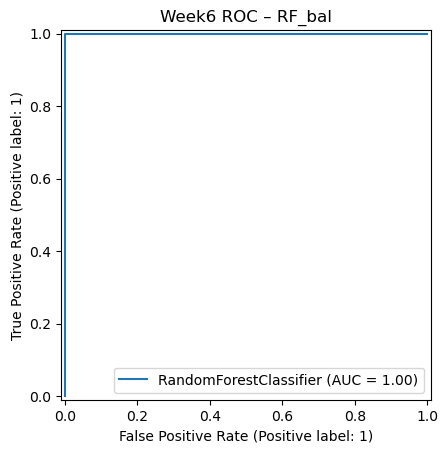

<Figure size 600x500 with 0 Axes>

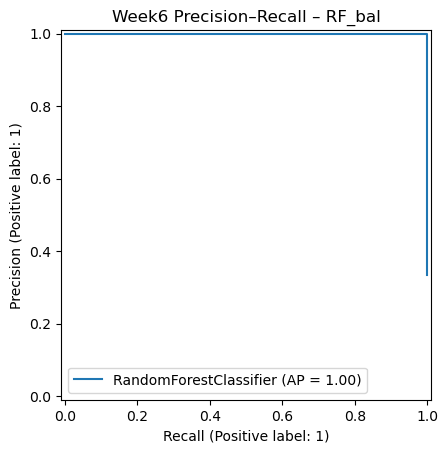

Saved model to ../models/week6_best_model.pkl


In [10]:

# Pick best model by val F1
def best_by_val(models_dict):
    best_name, best_model, best_f1 = None, None, -1
    for name, m in models_dict.items():
        f1 = f1_score(y_val, m.predict(X_val))
        if f1 > best_f1:
            best_name, best_model, best_f1 = name, m, f1
    return best_name, best_model

best_name, best_model = best_by_val(models)
print("Best (no SMOTE):", best_name)

# If SMOTE exists, compare
if HAS_SMOTE:
    best_name_sm, best_model_sm = best_by_val(models_sm)
    # Choose overall best
    cand = [(best_name, best_model), (best_name_sm, best_model_sm)]
    best_name, best_model = max(cand, key=lambda t: f1_score(y_val, t[1].predict(X_val)))
    print("Overall best considering SMOTE:", best_name)

# Test metrics
y_pred = best_model.predict(X_test)
print("\n=== TEST REPORT ===")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# Curves
fig_roc = plt.figure(figsize=(6,5))
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f"Week6 ROC – {best_name}")
plt.savefig(os.path.join(FIG_DIR, "week6_roc.png"), dpi=150, bbox_inches="tight")
plt.show()

fig_pr = plt.figure(figsize=(6,5))
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f"Week6 Precision–Recall – {best_name}")
plt.savefig(os.path.join(FIG_DIR, "week6_pr.png"), dpi=150, bbox_inches="tight")
plt.show()

# Save model
import joblib
joblib.dump(best_model, os.path.join(MODEL_DIR, "week6_best_model.pkl"))
print("Saved model to ../models/week6_best_model.pkl")
